# Load librarys

Procondition is that you have installed the with anaconda the packages listed in the NeuNe_notebook.yaml file.

```bash
conda env create -f NeuNe_notebook.yaml
```

```bash
conda activate NeuNe_notebook
```

```bash
conda env update --file NeuNe_notebook.yaml  --prune
```


This repository hosts a Convolutional Neural Network (CNN) model for brain tumor detection. Leveraging the dataset available on Kaggle [1], our classifier aims to accurately identify the presence of tumors in brain MRI images. Contributions to medical image analysis and early tumor detection are central to this project. The aim of the project was to create a simpler classifier than the one developed in the "Deep CNN for Brain Tumor Classification" paper [2], which aimed to create a classifier that could predict the tumor type based on given MRI scans.

🌐 Sources

https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor - Brain Tumor Dataset

https://link.springer.com/article/10.1007/s11063-020-10398-2 - Brain Tumor Classification




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
import random
import zipfile

# Load the images and create neural network model with TensorFlow 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


%matplotlib inline
plt.style.use('ggplot')

## Get Data and associate Labes

### Extract Data


In [2]:
# Extract the dataset
z = zipfile.ZipFile('archive.zip')

# Extract all the contents of zip file in current directory to a new folder named 'data'
z.extractall('data')

## Split Data into Tumor and Non-Tumor

This step is important to separate the data into two classes, tumor and non-tumor. This is important to train the model to distinguish between the two classes.


Number of images in tumor folder: 1683
Number of images in non_tumor folder: 2079


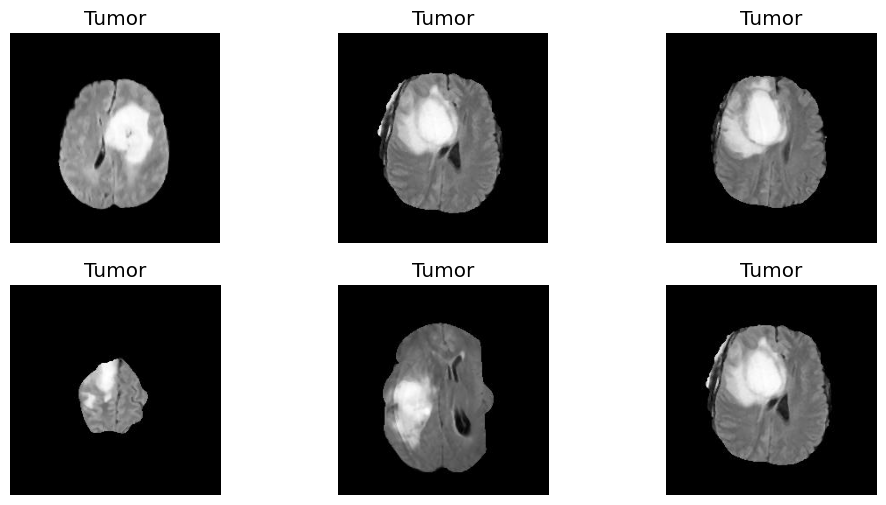

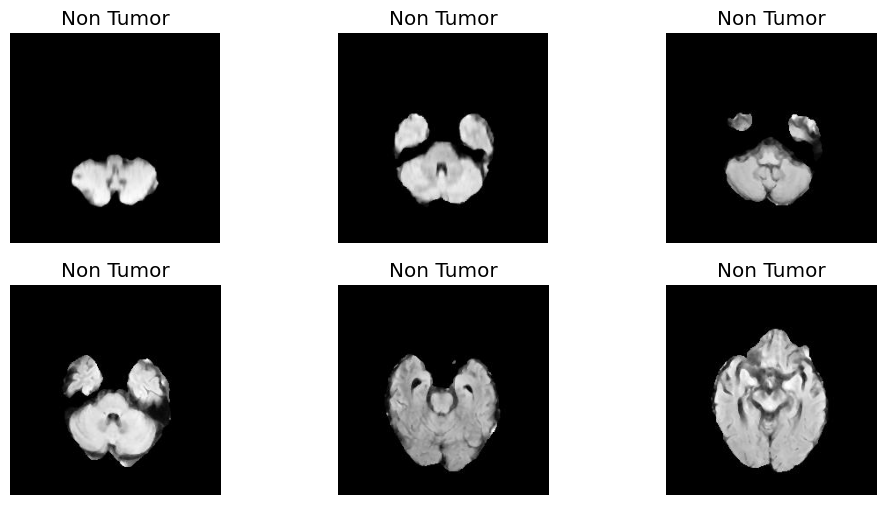

In [3]:
label_csv = pd.read_csv('data/Brain Tumor.csv')
label_csv.head()

image_folder = 'data/Brain Tumor/Brain Tumor'

# Save all the images to a folder named tumor and non_tumor
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Create the folders
os.makedirs(tumor_folder, exist_ok=True)
os.makedirs(non_tumor_folder, exist_ok=True)

# Copy the images to the folders
for index, row in label_csv.iterrows():
    image_path = os.path.join(image_folder, row['Image']+ '.jpg')
    if row['Class'] == 1:
        shutil.copy(image_path, tumor_folder)
    else:
        shutil.copy(image_path, non_tumor_folder)

# Check the number of images in each folder
print('Number of images in tumor folder:', len(os.listdir(tumor_folder)))
print('Number of images in non_tumor folder:', len(os.listdir(non_tumor_folder)))

# Display a few images from each folder
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(tumor_folder, os.listdir(tumor_folder)[i])))
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])))
    plt.title('Non Tumor')
    plt.axis('off')
plt.show()


### Analysis of Brain Tumor Image Dataset

#### Dataset Overview

The dataset consists of brain MRI images categorized into two classes: "Tumor" and "Non-Tumor." The images are stored in separate folders based on their class labels. Here's a summary of the data distribution:

- **Number of images in the "Tumor" folder:** 1683
- **Number of images in the "Non-Tumor" folder:** 2079

#### Data Visualization

To understand the dataset better, we visualized a sample of images from both classes.
These images provide a visual representation of the differences between tumor and non-tumor MRI scans. Tumor images typically show abnormal growths and irregular patterns, whereas non-tumor images exhibit normal brain structures without any noticeable anomalies.

#### Relevant Data Features

For the project, the key features to focus on are the visual characteristics of the MRI images that distinguish tumor from non-tumor cases. These features include:

- **Shape and Size:** Tumors usually have irregular shapes and varying sizes compared to normal brain tissue.
- **Texture:** Tumor regions often have different texture patterns compared to non-tumor regions.
- **Intensity:** The intensity values (brightness and contrast) in tumor regions can differ significantly from those in healthy brain tissue.


### Load Data with tensorflow as pipline

In this step we will load the data into the tensorflow pipeline. This is important to load the data in a way that the model can be trained.


Found 3762 files belonging to 2 classes.


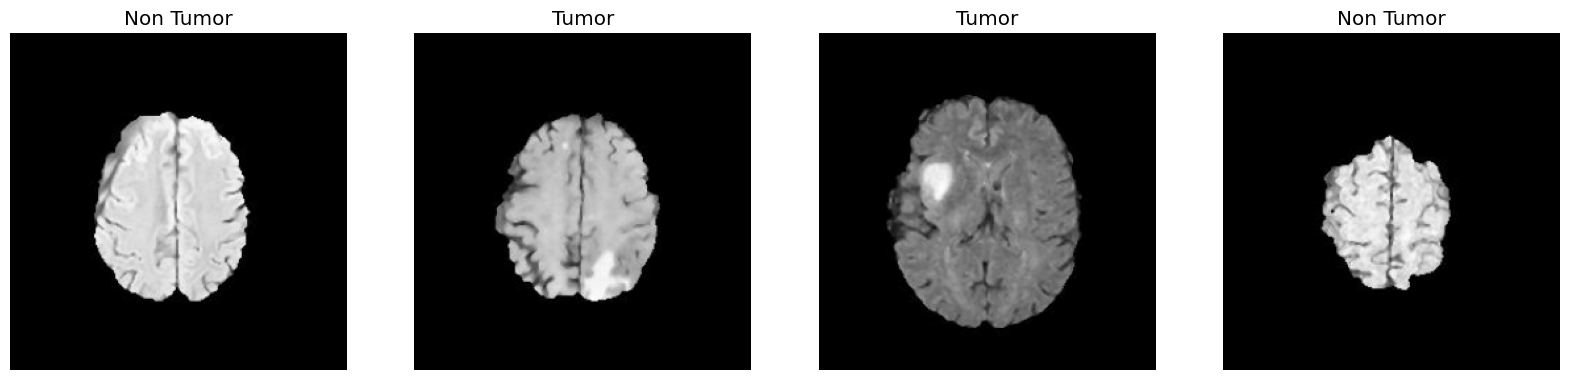

In [20]:
# building data pipeline
data = tf.keras.utils.image_dataset_from_directory('data/labeled')

# create a data iterator
data_iterator = data.as_numpy_iterator()

# creat a batch with 32 images
batch = data_iterator.next()

# images represented as numpy arrays
batch[0].shape

# plot the batch to see which class belongs to which image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # set the title of the image with tumor or non_tumor
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')
    ax[idx].axis('off')


## Preprocessing

### Data Scaling

In this step the data is normalized and scaled. In addition the data is converted to a grayscale image in order to have less features and to be able to train the model faster, as well as to reduce the risk of overfitting.
This can be done, as the data is anyway only black and white images.


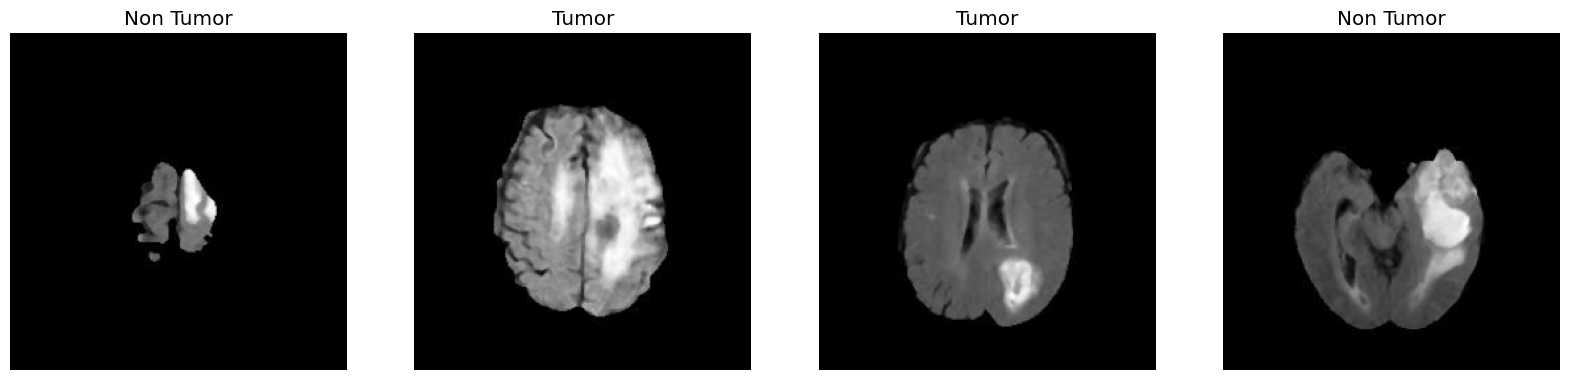

In [21]:
# scale the data pipline on the fly 
data_norm = data.map(lambda x, y: (x/255, y))

# preprocess the data to gray scale
data_gray = data.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

# create a scaled data iterator
scaled_interator = data_gray.as_numpy_iterator()
scaled_batch = scaled_interator.next()
scaled_batch[0].min()

# display the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')
    ax[idx].axis('off')

### Split Data

In this step the data is split into training, validation and test data. This is important to be able to evaluate the model on unseen data.


In [22]:
# decide the size of the train, validation and test datasets
print(len(data_gray))
train_size = int(len(data_gray)*.7)
val_size = int(len(data_gray)*.2)+1
test_size = int(len(data_gray)*.1)+1

# calculate the total number of batches
total_batches = train_size + val_size + test_size

print("Total number of batches:", total_batches)
# this number is not exact because the last batch may not have 32 images
print("Total number of images (not exact):", total_batches*32)

118
Total number of batches: 118
Total number of images (not exact): 3776


In [23]:
# split the data into train, validation and test
train = data_gray.take(train_size)
val = data_gray.skip(train_size).take(val_size)
test = data_gray.skip(train_size+val_size).take(test_size)

print(f"Train: {len(train)} batches, Validation: {len(val)} batches, Test: {len(test)} batches")

Train: 82 batches, Validation: 24 batches, Test: 12 batches


### Data Augementation

This step is important to increase the amount of data and to reduce the risk of overfitting. It was one of the most challenging steps, as we had to find the right parameters to increase the data and to not overfit the model, but also not make the data too different from the original data.


In [24]:
# Define data augmentation only for training
train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=None),
    tf.keras.layers.RandomBrightness(0.1, value_range=(0, 255))
])

# Apply augmentation to the training dataset
train_augmented = train.map(lambda x, y: (train_data_augmentation(x, training=True), y))

# Define the percentage of augmented data
augmented_data_percentage = 0.4

# Calculate the number of augmented images
augmented_data_size = int(len(train) * augmented_data_percentage*32)

print('Number of augmented images:', augmented_data_size)

# combine the augmented data with the original data
train_combined = train.concatenate(train_augmented.take(augmented_data_size)).shuffle(1000)

print('Number of images in the combined dataset:', len(train_combined) * 32)


Number of augmented images: 1049
Number of images in the combined dataset: 5248


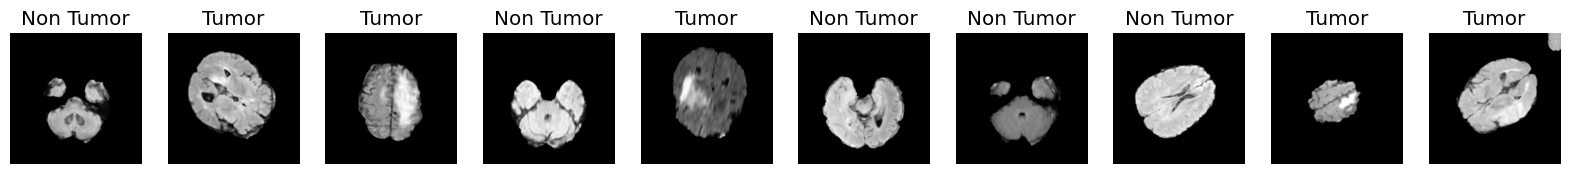

In [25]:
# display some picture of the train_combined dataset
fig, ax = plt.subplots(ncols=10, figsize=(20, 20))
for idx, img in enumerate(train_combined.take(10)):
    ax[idx].imshow(img[0][0], cmap='gray')
    ax[idx].title.set_text('Tumor' if img[1][0] == 1 else 'Non Tumor')
    ax[idx].axis('off')

## Model Creation and Compilation

In this step the model is created and compiled. Important was to have in the last layer only one neuron, with a sigmoid acitvation, as we have a binary classification problem. The other parameters were chosen on try and error basis. Except for the input shape, which was chosen to be the size of the images.

### Model Architecture

- **Input Layer:** The input layer takes grayscale images of size 128x128 pixels.
- **Convolutional Layers:** The model consists of three convolutional layers with ReLU activation functions and max pooling layers to extract features from the input images.
- **Flatten Layer:** The flatten layer converts the 2D feature maps into a 1D feature vector.
- **Dense Layers:** The model includes two dense layers with ReLU activation functions to learn complex patterns from the extracted features.
- **Output Layer:** The output layer has a single neuron with a sigmoid activation function for binary classification (tumor or non-tumor).


In [17]:
# Create a neural network model which loads the images and classifies them as tumor or non-tumor and the csv file with values like standard deviation, mean, etc.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), BinaryAccuracy(), 'accuracy'])

# Train the model
history = model.fit(train_combined, validation_data=val, epochs=10, callbacks=[EarlyStopping(patience=3)])


# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and loss log scale
# This is usefull because the loss is very high in the beginning and then it decreases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (log scale)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

# plot the precision and recall
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_3" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, None, 256, 256)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 256, 256, 1), dtype=float32)
  • training=True
  • mask=None

### Hyperparameter Tuning

In this step the hyperparameters were tuned. This was done by try and error. The most important hyperparameters were the learning rate, the batch size and the number of epochs. The goal was to find the right parameters to train the model as fast as possible, but also to have a good accuracy. This was done by training the model with different parameters and then evaluating the model on the validation data.

In [26]:
import kerastuner as kt


# Define the model-building function for KerasTuner
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), 3, padding='same', activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D(),
        Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), 
                  loss='binary_crossentropy', 
                  metrics=[Precision(), Recall(), BinaryAccuracy(), 'accuracy'])
    return model

# Define the hyperparameters
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    0
    max_epochs=10,
    hyperband_iterations=2,
    directory='model/hyperparametertuning',
    project_name='tumor_detection'
)

# Search for the best hyperparameters
tuner.search(train_combined, validation_data=val)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_combined, validation_data=val, epochs=10, callbacks=[EarlyStopping(patience=3)])

# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and loss log scale
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (log scale)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

# plot the precision and recall
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

Trial 14 Complete [00h 08m 25s]
val_accuracy: 0.8606770634651184

Best val_accuracy So Far: 0.8606770634651184
Total elapsed time: 01h 44m 08s

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
64                |48                |conv1_units
64                |32                |conv2_units
128               |192               |conv3_units
1024              |768               |dense_units
rmsprop           |adam              |optimizer
4                 |4                 |tuner/epochs
0                 |2                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.6863 - binary_accuracy: 0.6863 - loss: 167.4912 - precision: 0.6699 - recall: 0.5959 - val_accuracy: 0.7682 - val_binary_accuracy: 0.7682 - val_loss: 0.4773 - val_precision: 0.8390 - val_recall: 0.5426
Epoch 2/4
164/164 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/s

## Evaluate Performance

In this step the model is evaluated on the test data. This is important to see how well the model performs on unseen data.


In [11]:
# Messures used for classification problems, precision, recall and accuracy. 
# Establish instance of precision, recall and accuracy
pre =  Precision()
re = Recall()
acc = BinaryAccuracy()

# Iterate over the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Reshape yhat if necessary to match the dimensions of y
    if yhat.shape[-1] == 1:
        yhat = tf.squeeze(yhat, axis=-1)  # Squeeze the last dimension

    # Update metric states
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)  # Here, we correctly use BinaryAccuracy

print('Precision:', pre.result().numpy())
print('Recall:', re.result().numpy())
print('Accuracy:', acc.result().numpy())

# Calculate the AUC
auc = roc_auc_score(y, yhat)
print('AUC:', auc)

# Calculate the F1 score
f1 = f1_score(y, yhat > 0.5)
print('F1:', f1)

# Print the results after processing all batches


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Precision: 0.87573963
Recall: 0.91358024
Accuracy: 0.9088542
AUC: 1.0
F1: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


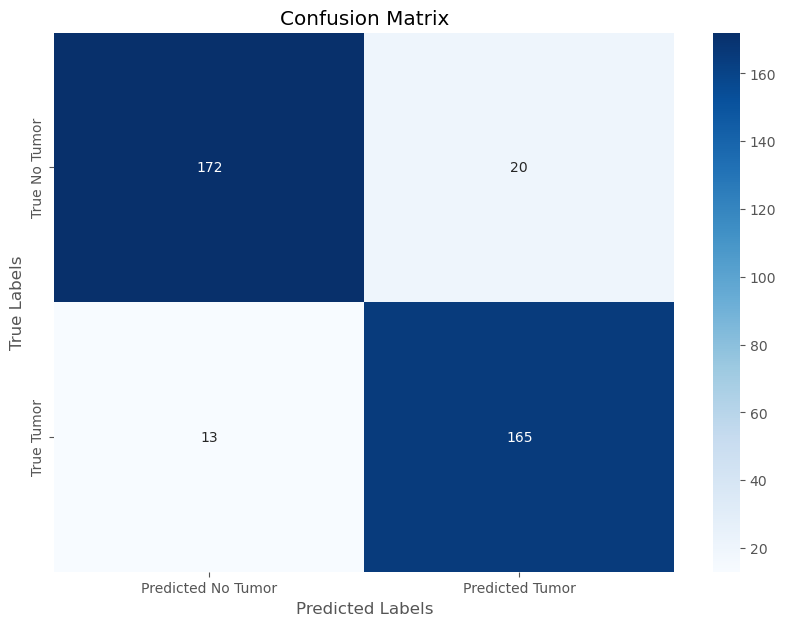

True Negatives (No Tumor): 172
False Positives (No Tumor but shows Tumor): 20
False Negatives (Tumor but shows No Tumor): 13
True Positives (Tumor): 165


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect all true labels and predicted labels
all_y_true = []
all_y_pred = []

# Iterate over the test dataset again to collect true and predicted labels
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Reshape yhat if necessary to match the dimensions of y
    if yhat.shape[-1] == 1:
        yhat = tf.squeeze(yhat, axis=-1)  # Squeeze the last dimension

    # Collect the true and predicted labels for confusion matrix
    all_y_true.extend(y)
    all_y_pred.extend(yhat)

# Convert lists to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred > 0.5)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Tumor', 'Predicted Tumor'], yticklabels=['True No Tumor', 'True Tumor'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Extract and print detailed counts with descriptions
tn, fp, fn, tp = cm.ravel()
print(f'True Negatives (No Tumor): {tn}')
print(f'False Positives (No Tumor but shows Tumor): {fp}')
print(f'False Negatives (Tumor but shows No Tumor): {fn}')
print(f'True Positives (Tumor): {tp}')


### Prediction on Random Images

In this section the model evaluates some random images from the data set. This is just for try and error and has no big impact on the evaluation of the model, as the most images are already seen by the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


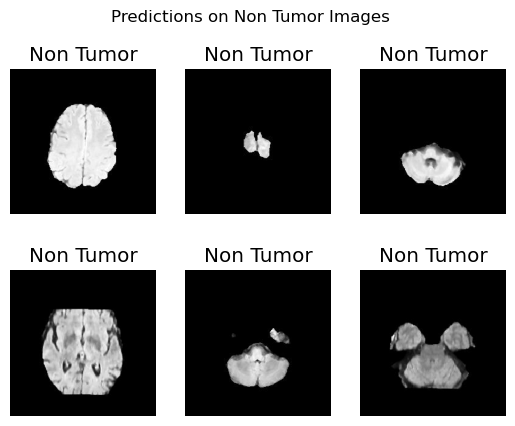

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


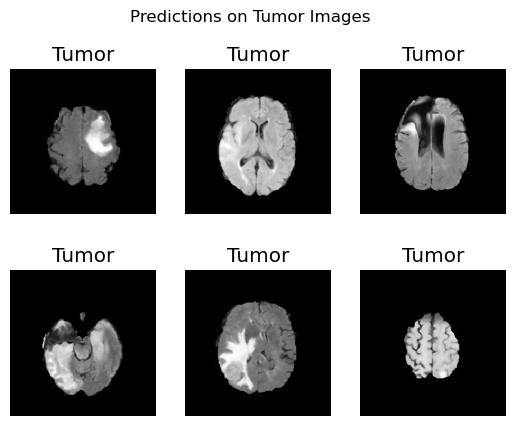

In [13]:
# Predictions on test dataset and display the images
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Make 6 predictions on the test dataset without tumor
non_tumor_folder_random_images = os.listdir(non_tumor_folder)

# select 6 random images
random.shuffle(non_tumor_folder_random_images)

for i, image in enumerate(non_tumor_folder_random_images[:6]):
    img = tf.keras.preprocessing.image.load_img(os.path.join(non_tumor_folder, image), target_size=(256, 256), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Non Tumor' if prediction < 0.5 else 'Tumor')
    plt.axis('off')
    plt.suptitle('Predictions on Non Tumor Images')
plt.show()

tumor_folder_random_images = os.listdir(tumor_folder)

# select 6 random images
random.shuffle(tumor_folder_random_images)

# Make 6 predictions on the test dataset with tumor
for i, image in enumerate(tumor_folder_random_images[:6]):
    img = tf.keras.preprocessing.image.load_img(os.path.join(tumor_folder, image), target_size=(256, 256), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    prediction = model.predict(img_array)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Non Tumor' if prediction < 0.5 else 'Tumor')
    plt.axis('off')
    plt.suptitle('Predictions on Tumor Images')

## Save the Model

In this step the model is saved. This is important to be able to use the model later on for predictions.


In [14]:
# Create the model folder
os.makedirs('model', exist_ok=True)

# Save the model
model.save(os.path.join('model', 'brain_tumor_classifier.keras'))

# save the model in the h5 format which is outdated but still used by some applications
model.save('model/brain_tumor_classifier.h5')

# Showcase the Model

Now you can use the model to predict the class of any brain MRI image.

Create for that a new virtual environment and install the required libraries:

```bash
pip install -r requirements.txt
```

Then you can start the streamlit app with the following command:

```bash
streamlit run dashboard.py
```


## Conclusion

### Next Steps

The next steps would be to improve the model by using a more complex model. In addition, the data augmentation could be improved by using more parameters and more data. Also, the model could be trained on more data, as the data set was quite small. Also the model could use additional data, such as the mean, variance or standard deviation of the pictures. Other interesting parameters would be to use patient data, such as Age and Sex.
In addition, the model could be improved by doing a hyperparameter tuning, to find the best parameters for the model.
A feature selection could also be done, to find the most important features for the model, but we did not do that as the pictures are already quite small and the model is already quite simple and we would risk to cut important features during data augmentation.
